# Introduction

The hypothetical Sweet Lift Taxi company has collected historical data on taxi orders at airports. To secure more drivers during peak hours, the business needs to predict the amount of taxi orders on an hourly basis. We will build a time series model for such a prediction.

1. Because we need to predict hourly taxi usage, we should prep our data for hourly prediction, which requires resampling.
2. We will conduct a brief EDA to analyze the data.
3. This dataset could perform well under any one of multiple models. We'll train a few models tuning over a few hyperparameters each. The test sample will be 10% of the initial dataset. 
4. We'll evaluate the models by asking them to predict taxi activity based on the test sample and provide a conclusion on model performance.

## Data description

The data is stored in file `sweet_lift.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

### Initialize Libraries

In [1]:
# Statistical libraries
import pandas as pd
import numpy as np
from sklearn.metrics import *
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import ar_select_order

# Graphing libraries
from matplotlib import pyplot as plt

### Look at Dataframe

In [2]:
# Read Dataframe
df_raw = pd.read_csv('./datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# Quick look
df_raw.info()
display(df_raw.head(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


All we have is a series of 26,496 time points corresponding to the number of taxi orders fulfilled during a given 10-minute time frame. We can engineer new features upon this basic time series, but on its own, this `num_orders` column is nothing more than an evenly-metered numeric variable undergoing change.

### Check for Duplicates, Monotonicity

In [4]:
# Duplicates?
display(df_raw.loc[df_raw.index.duplicated()])

,num_orders
datetime,


There are no duplicate time indices, indicating a healthy time series. We will check for monotonicity (a general trend of the time series value upward or downward) to know how to handle the time series.

In [8]:
# Monotonicity?
print(df_raw.index.is_monotonic_increasing)

True


In [9]:
# Cleanup
df = df_raw.copy()
del df_raw

### Resample to Hourly

In [10]:
# We'll use the built-in resample function to resample the data
df.sort_index(inplace=True)
df = df.resample('1H').sum()

C:\Users\brian\AppData\Local\Temp\ipykernel_17840\427693933.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum()


### Determine AR / MA Orders and Number of Lags to Include

We are interested in which hours may be correlated to each other. The gap between these hours is a lag. For our analysis we will simply use the highest number that the AR lag analysis indicates to use when creating new lag features.

In [11]:
# AR Order
mod = ar_select_order(
    endog=df, 
    maxlag=30,
    trend='ct',
    seasonal=True,
    period=24,
    missing='drop'
)
ar_order = mod.ar_lags
print('AR ORDER:', ar_order)

# Determine best number of lags to include
best_lags = mod.ar_lags[-1]

AR ORDER: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


### Create Feature-based Dataframe

In [12]:
# Use data of series to create new features
df_expanded = df.copy()

# Create features
df_expanded['month'] = df_expanded.index.month
df_expanded['day'] = df_expanded.index.day
df_expanded['dayofweek'] = df_expanded.index.dayofweek
df_expanded['hour'] = df_expanded.index.hour

for lag in range(1, best_lags):
    df_expanded[('lag_' + str(lag))] = df_expanded['num_orders'].shift(lag)

df_expanded['rolling_mean'] = df_expanded['num_orders'].shift().rolling(best_lags).mean()

## Analysis

When looking at time series data, it's important to understand what regular (i.e. seasonal) changes make up the data. Seasonal changes sum to zero in each seasonal epoch (in our case, one day). Using the seasonal_decompose function from the `statsmodel` distribution, we can isolate the seasonal components (DecomposeResult.seasonal) from the noise (DecomposeResult.resid) and the overall trend upward of taxi orders (DecomposeResult.trend). Below we'll graph the seasonal component to take a look at when daily taxi use tends to surge and dwindle.

In [13]:
# Preliminary seasonal analysis
decomposed = seasonal_decompose(df)

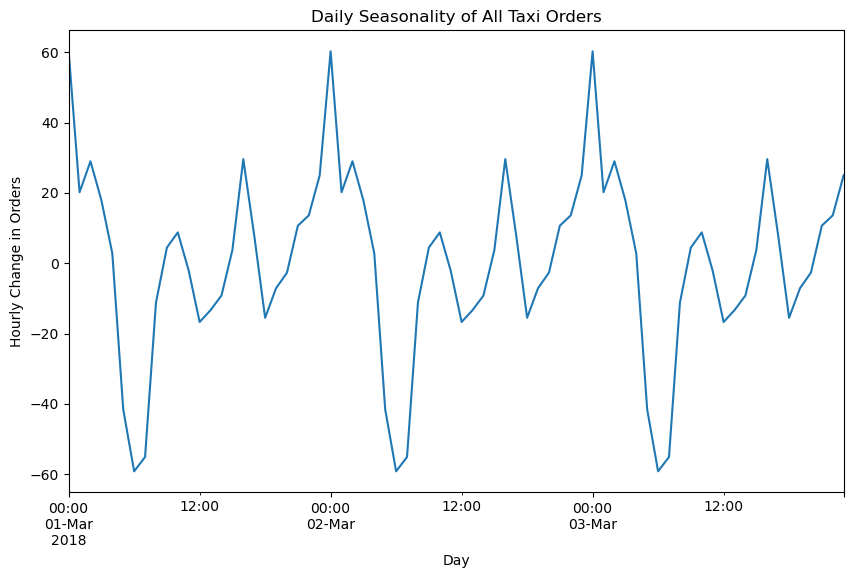

In [14]:
# Plot Daily Seasonality
plt.figure(figsize=(10,6))
decomposed.seasonal[:(3*24)].plot(ax=plt.gca())
plt.xlabel('Day')
plt.ylabel('Hourly Change in Orders')
plt.title('Daily Seasonality of All Taxi Orders')
plt.show()

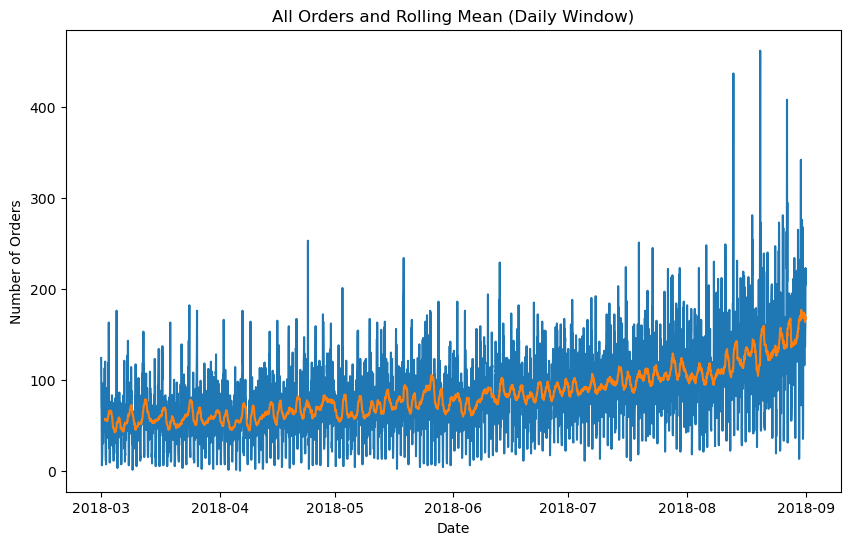

In [15]:
# Plot All Data w/ Rolling Mean
plt.figure(figsize=(10,6))
plt.plot(df_expanded['num_orders'])
plt.plot(df_expanded['rolling_mean'])
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.title('All Orders and Rolling Mean (Daily Window)')
plt.show()

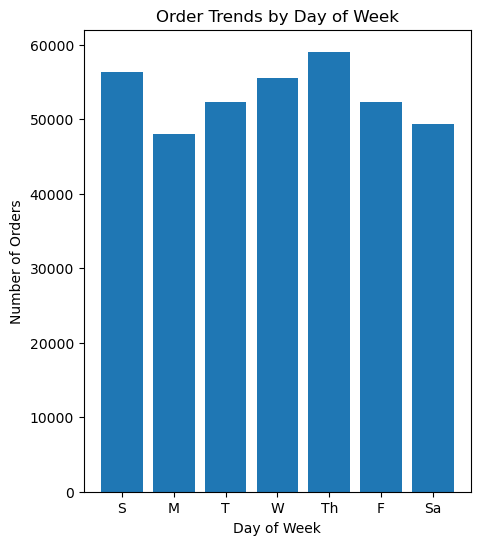

In [16]:
# Plot All Data w/ Rolling Mean
by_dow = df_expanded.groupby('dayofweek')['num_orders'].sum()

plt.figure(figsize=(5,6))
plt.bar(x=range(0, 7), height=by_dow)
plt.xlabel('Day of Week')
plt.xticks(ticks=range(0, 7), labels=['S', 'M', 'T', 'W', 'Th', 'F', 'Sa'])
plt.ylabel('Number of Orders')
plt.title('Order Trends by Day of Week')
plt.show()

## Training

### Baseline Linear Regression

#### Split Into Train/Test Sets

In [17]:
# Split data to get a forecast horizon of 10% of the total data
features_train, features_test, target_train, target_test = train_test_split(
    df_expanded.drop(['num_orders'], axis=1), # features
    df_expanded['num_orders'], # target
    shuffle=False, 
    test_size=0.1
)

# Find NaN values in features_train and remove them, changing the indices of target_train to match
problem_indices = features_train[features_train.isna().any(axis=1)].index
features_train = features_train.drop(problem_indices)
target_train = target_train.drop(problem_indices)

#### Train Linear Regression

In [18]:
# Simply baseline Linear Regression
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

LinearRegression()

#### Evaluate

In [19]:
# Evaluate Linear Regression
lr_predict = lr_model.predict(features_test)

In [20]:
# RMSE
lr_rmse = mean_squared_error(target_test, lr_predict)**(1/2)

# Store lr predictions
lr_predictions = np.zeros(len(target_train) + len(target_test))
lr_predictions[:len(target_train)] = np.nan #LEFT-SIDE ARRAY PADDING
lr_predictions[len(target_train):] = lr_predict

# Store lr actual
lr_actual = np.zeros(len(target_train) + len(target_test))
lr_actual[:len(target_train)] = target_train
lr_actual[len(target_train):] = target_test

#### Cleanup to Conserve Resources

In [21]:
# Cleanup
del lr_model, features_train, features_test, target_train, target_test

### SARIMAX Model

Our model is nonstationary for certain because it is clearly seasonal and has a strong trend element, and thus we prefer an ARIMA model to a simple ARMA model. We will use the SARIMAX, which incorporates seasonality to its autoregression.

#### Split Into Train/Valid/Test Sets

In [22]:
# Return train/test at ratio of 9:1
train, test = train_test_split(df, shuffle=False, test_size=0.1)

# Create tiny training set for determining best orders to prevent kernel from crashing
majority_train, minority_train = train_test_split(train, shuffle=False, test_size=0.111111)

#### Initialize

In [23]:
# SARIMAX Paramaters
sarimax_params = {
    'enforce_stationarity': False,
    'enforce_invertibility': False
}

# Ranges for p, d, q and seasonal P, D, Q
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
s = 24  # Daily seasonality

In [24]:
# Function to get best SARIMAX order hyperparams
def get_best_orders(train, p_range, d_range, q_range, P_range, D_range, Q_range, s):
    best_aic = 999999
    best_order = None
    best_seasonal_order = None

    for p in p_range:
        for d in d_values:
            for q in d_range:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                sarimax_model = SARIMAX(
                                    minority_train, 
                                    order=(p, d, q), 
                                    seasonal_order=(P, D, Q, s),
                                    **sarimax_params
                                )
                                sarimax_model_fit = sarimax_model.fit(disp=False)
                                if sarimax_model_fit.aic < best_aic:
                                    best_aic = sarimax_model_fit.aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, s)
                            except:
                                continue
    return best_order, best_seasonal_order

#### Train SARIMAX

In [25]:
best_order, best_seasonal_order = get_best_orders(train, p_values, d_values, q_values, P_values, D_values, Q_values, s)

c:\Users\brian\anaconda3\envs\DSPortfolio\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\brian\anaconda3\envs\DSPortfolio\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\brian\anaconda3\envs\DSPortfolio\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
# Train the best SARIMA model and predict
sarimax_model = SARIMAX(
    train, 
    order = best_order, 
    seasonal_order = best_seasonal_order,
    **sarimax_params
)
sarimax_model = sarimax_model.fit(disp=False)

#### Evaluate

In [27]:
sarimax_pred = sarimax_model.forecast(steps=len(test))
sarimax_rmse = mean_squared_error(test, sarimax_pred)**(1/2)

In [28]:
# Store arima predictions
sarimax_predictions = np.zeros(len(df))
sarimax_predictions[:len(train)] = np.nan 
sarimax_predictions[len(train):] = sarimax_pred

# Store arima actual
sarimax_actual = np.array(df['num_orders'])

#### Cleanup to Conserve Resources

In [29]:
# Cleanup
del train, test, majority_train, minority_train

### RandomForest Regression

#### Split Into Train/Valid/Test Sets

In [30]:
# Split data for hyperparameter tuning of train/valid/test at 9:1
features_train, features_test, target_train, target_test = train_test_split(
    df_expanded.drop(['num_orders'], axis=1), # features
    df_expanded['num_orders'], # target
    shuffle=False, 
    test_size=0.1
)

# Find NaN values in features_train and remove them, changing the indices of target_train to match
problem_indices = features_train[features_train.isna().any(axis=1)].index
features_train = features_train.drop(problem_indices)
target_train = target_train.drop(problem_indices)

#### Initialize

In [31]:
parameter_grid = {
    'n_estimators': [6, 10],
    'max_depth': [4, 6, 8],
    'min_samples_split': [4, 6],
    'min_samples_leaf': [4, 6]
}
forest = RandomForestRegressor(
    random_state=12345, n_jobs = -1
)
cross_validator = KFold(
    n_splits=4, shuffle=True, random_state=12345
)
forest_GSCV = GridSearchCV(
    estimator=forest, param_grid=parameter_grid, scoring = 'neg_root_mean_squared_error', cv = cross_validator, verbose=3
)

#### Find Optimal Hyperparams and RF Model

In [32]:
# Random Forest Grid Search
forest_GSCV.fit(features_train, target_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV 1/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=6;, score=-26.955 total time=   0.0s
[CV 2/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=6;, score=-26.866 total time=   0.0s
[CV 3/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=6;, score=-26.237 total time=   0.0s
[CV 4/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=6;, score=-26.299 total time=   0.0s
[CV 1/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=10;, score=-26.898 total time=   0.0s
[CV 2/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=10;, score=-26.914 total time=   0.0s
[CV 3/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=10;, score=-25.583 total time=   0.0s
[CV 4/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=10;, score=-26.413 total time=   0.0s

GridSearchCV(cv=KFold(n_splits=4, random_state=12345, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=12345),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 6], 'n_estimators': [6, 10]},
             scoring='neg_root_mean_squared_error', verbose=3)

#### Evaluate

In [33]:
rf_model = RandomForestRegressor(
    random_state=12345, n_jobs=-1, **forest_GSCV.best_params_
)
rf_model.fit(features_train, target_train)
rf_predict = rf_model.predict(features_test)
rf_rmse = mean_squared_error(target_test, rf_predict)**(1/2)

In [34]:
# Store rf predictions
rf_predictions = np.zeros(len(target_train) + len(target_test))
rf_predictions[:len(target_train)] = np.nan 
rf_predictions[len(target_train):] = rf_predict

# Store rf actual
rf_actual = np.zeros(len(target_train) + len(target_test))
rf_actual[:len(target_train)] = target_train
rf_actual[len(target_train):] = target_test

#### Cleanup to Conserve Resources

In [35]:
del forest_GSCV, cross_validator, rf_model, forest, problem_indices, features_train, features_test, target_train, target_test

## Testing

### Evaluate Baseline (Linear Regression)

In [36]:
print('Linear Regression Model RMSE:')
print(lr_rmse)

Linear Regression Model RMSE:
45.81094888906948


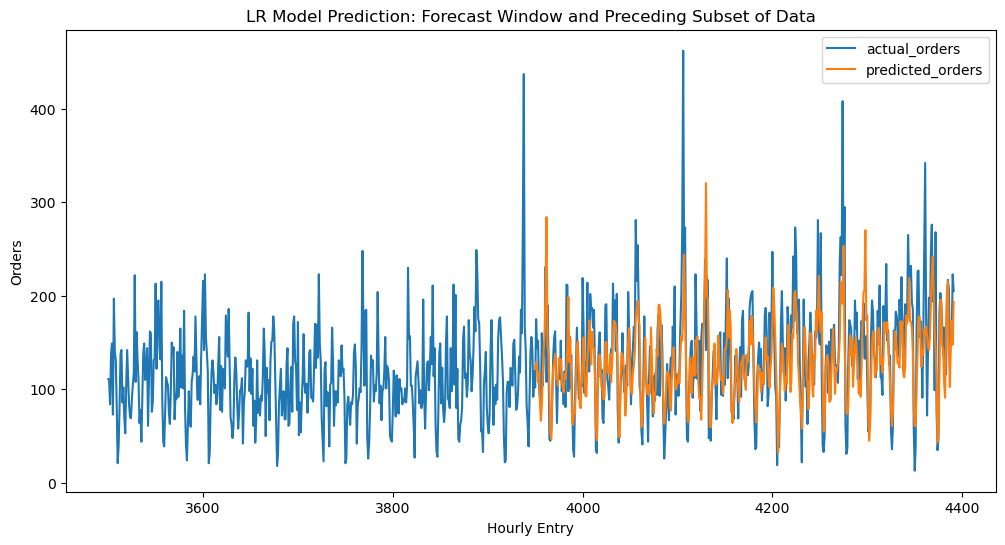

In [37]:
# Plottable dataframe
lr_plot_data = pd.DataFrame(
    {
        'actual_orders': lr_actual,
        'predicted_orders': lr_predictions
    }
)

# Plot
fig = plt.figure(figsize=(12,6))
lr_plot_data[3500:].plot(ax=plt.gca())
plt.xlabel('Hourly Entry')
plt.ylabel('Orders')
plt.title('LR Model Prediction: Forecast Window and Preceding Subset of Data')
plt.show()

### Evaluate Time Series Model (SARIMAX)

In [38]:
print('SARIMAX Model RMSE:')
print(sarimax_rmse)

SARIMAX Model RMSE:
45.16813679677071


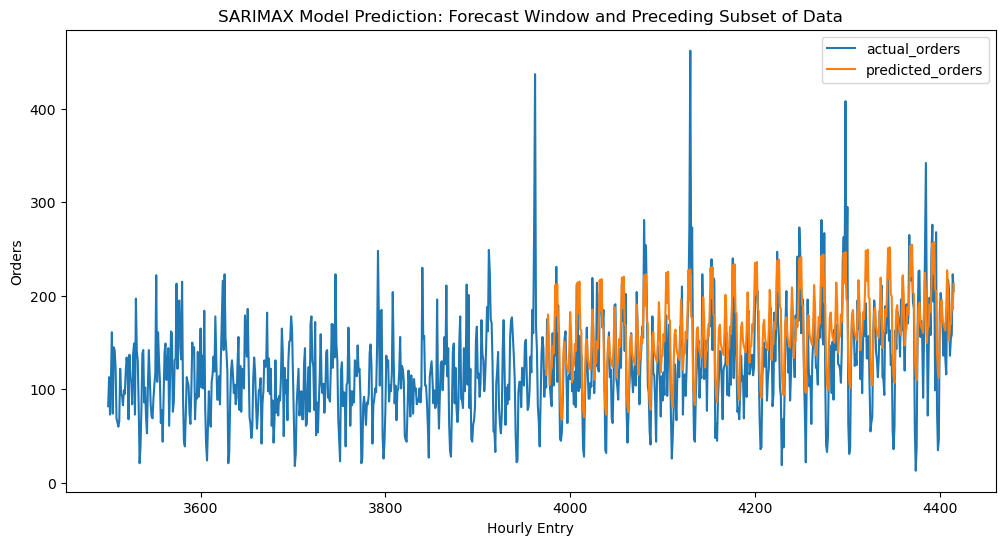

In [39]:
# Plottable dataframe
sarimax_plot_data = pd.DataFrame(
    {
        'actual_orders': sarimax_actual,
        'predicted_orders': sarimax_predictions
    }
)

# Plot
fig = plt.figure(figsize=(12,6))
sarimax_plot_data[3500:].plot(ax=plt.gca())
plt.xlabel('Hourly Entry')
plt.ylabel('Orders')
plt.title('SARIMAX Model Prediction: Forecast Window and Preceding Subset of Data')
plt.show()

### Evaluate Random Forest Regression

In [40]:
print('Random Forest Regression Model RMSE:')
print(rf_rmse)

Random Forest Regression Model RMSE:
46.21399886662175


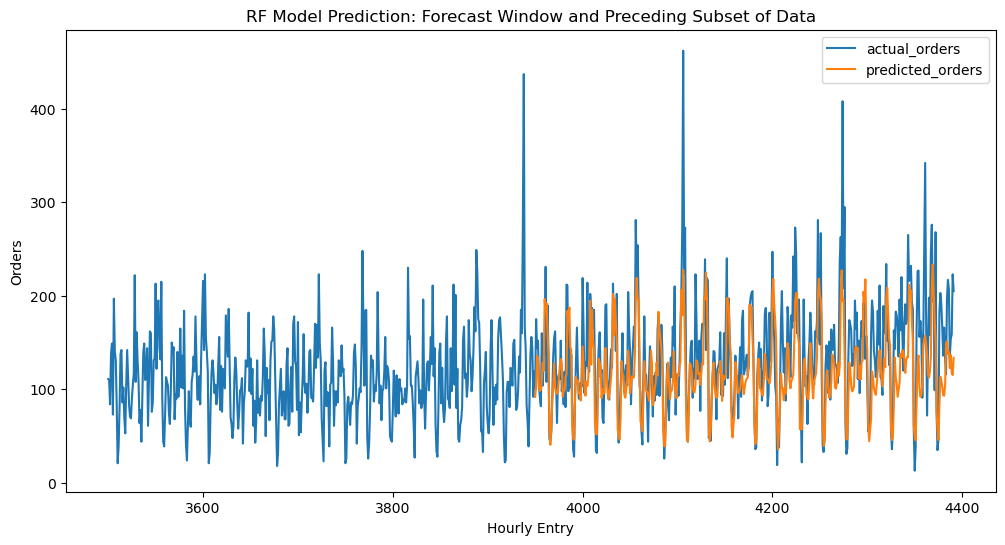

In [41]:
# Plottable dataframe
rf_plot_data = pd.DataFrame(
    {
        'actual_orders': rf_actual,
        'predicted_orders': rf_predictions
    }
)

# Plot
fig = plt.figure(figsize=(12,6))
rf_plot_data[3500:].plot(ax=plt.gca())
plt.xlabel('Hourly Entry')
plt.ylabel('Orders')
plt.title('RF Model Prediction: Forecast Window and Preceding Subset of Data')
plt.show()

#### Conclusion

When tuning the Linear Regression and Random Forest models, we used an expanded dataframe that took into account datetime features and 24 lag-value-adjusted features. The SARIMAX model relied on the simple time series of the 'num_orders' column. For all models our prediction window was the final 10% of the dataset, or the final 18 days of the set. The above graphs plot the actual values against the model predictions for this final window.

All three models had comparable RMSE values around 45. The lowest was SARIMAX at 45.168137. This indicates that accounting more heavily on 24-hour seasonality is an advantage.

The Linear Regression and Random Forest models were quick to train and performed well despite not taking AR or MA modeling into account.